In [18]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plot
import time

In [19]:
# Defining Functions
def gsLEX(u, f, nu):
    """
    Applies the Gauss-Seidel relaxation method to iteratively solve a partial differential equation (PDE).
    
    Parameters:
    - u (numpy.ndarray): 2D array representing the initial guess for the solution of the PDE.
    - f (numpy.ndarray): 2D array representing the right-hand side (RHS) function of the PDE.
    - nu (int): Number of relaxation iterations to perform.
    
    Returns:
    - u (numpy.ndarray): Updated 2D array representing the solution of the PDE after relaxation iterations.
    
    This function applies the Gauss-Seidel relaxation method, an iterative numerical technique, to approximate
    the solution of a discretized partial differential equation. It updates the solution `u` in place based on
    the given initial guess, the RHS function `f`, and the specified grid parameters. The number of relaxation
    iterations `nu` determines the accuracy of the approximation. The function takes into account the grid
    spacing `h` to perform the computations on the discrete grid.
    """
    N = len(u)
    h = 1 / (N - 1)
    
    for _ in range(nu):
        for j in range(1, N - 1):
            for i in range(1, N - 1):
                u[i, j] = (h**2 * f[i, j] + u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1]) / 4
    
    return u

def residual(u, f):
    """
    Computes the residual of a discretized partial differential equation (PDE) using the given solution `u`
    and the right-hand side (RHS) function `f`.
    
    Parameters:
    - u (numpy.ndarray): 2D array representing the current approximation of the solution.
    - f (numpy.ndarray): 2D array representing the right-hand side function of the PDE.
    
    Returns:
    - r (numpy.ndarray): 2D array representing the residual of the PDE after applying the discretized operator.
    
    This function calculates the residual of the discretized PDE using finite differences.
    It computes the difference between the RHS function `f` and the Laplacian of `u` (approximated 
    using central differences). The residual measures the error in the current solution approximation.
    """
    N = len(u)
    h = 1 / (N - 1)
    r = np.zeros((N, N))
    
    for j in range(1, N - 1):
        for i in range(1, N - 1):
            r[i, j] = f[i, j] + (u[i-1, j] - 2*u[i, j] + u[i+1, j] + u[i, j-1] - 2*u[i, j] + u[i, j+1]) / h**2

    return r

def resInfNorm(r):
    """
    Computes the infinity norm of a 2D array representing the residual of a partial differential equation (PDE).
    
    Parameters:
    - r (numpy.ndarray): 2D array representing the residual of the PDE after discretization.
    
    Returns:
    - r_inf (float): Infinity norm of the residual, indicating the maximum absolute value of the elements in the array.
    
    This function calculates the infinity norm (also known as the maximum norm) of a 2D array representing the residual
    of a discretized partial differential equation (PDE). The infinity norm measures the maximum absolute value of the
    elements in the array, providing a quantitative measure of the error in the current approximation of the solution.
    """
    return np.abs(np.max(r))

def restrict(u):
    """
    Restricts the given 2D array `u` to a coarser grid using full-weighting interpolation.
    
    Parameters:
    - u (numpy.ndarray): 2D array representing the solution to be restricted.
    
    Returns:
    - u_2h (numpy.ndarray): 2D array representing the restricted solution on a coarser grid.
    
    This function restricts the solution `u` to a coarser grid using full-weighting interpolation.
    """
    N_c = int((len(u) - 1) / 2)
    u_2h = np.zeros((N_c + 1, N_c + 1))
    
    for i in range(1, N_c):
        ii = 2 * i 
        for j in range(1, N_c):
            jj = 2 * j 
            u_2h[i, j] = (u[ii-1, jj-1] + 2*u[ii, jj-1] + u[ii+1, jj-1] + 2*u[ii-1, jj] + 4*u[ii, jj] +
                          2*u[ii+1, jj] + u[ii-1, jj+1] + 2*u[ii, jj+1] + u[ii+1, jj+1]) / 16
    
    return u_2h

def prolong(u_2h):
    """
    Prolongs the given solution `u_2h` from a coarser grid to a finer grid using linear interpolation.
    
    Parameters:
    - u_2h (numpy.ndarray): 2D array representing the solution on a coarser grid.
    
    Returns:
    - u_h (numpy.ndarray): 2D array representing the solution on the finer grid after prolongation.
    
    This function prolongs the solution `u_2h` from a coarser grid to a finer grid using linear interpolation.
    """
    N_c = len(u_2h)
    N = 2 * (N_c - 1)
    u_h = np.zeros((N + 1, N + 1))
    
    for i in range(1, N_c - 1):
        ii = 2 * i 
        for j in range(1, N_c - 1):
            jj = 2 * j 
            u_h[ii-1, jj-1] += u_2h[i, j] / 4
            u_h[ii, jj-1] += u_2h[i, j] / 2
            u_h[ii+1, jj-1] += u_2h[i, j] / 4
            u_h[ii-1, jj] += u_2h[i, j] / 2
            u_h[ii, jj] += u_2h[i, j]
            u_h[ii+1, jj] += u_2h[i, j] / 2
            u_h[ii-1, jj+1] += u_2h[i, j] / 4
            u_h[ii, jj+1] += u_2h[i, j] / 2
            u_h[ii+1, jj+1] += u_2h[i, j] / 4
    
    return u_h

def multiGrid(u_0, f, gamma, nu1, nu2):
    """
    Performs the multigrid algorithm to iteratively solve a partial differential equation (PDE) on a grid.
    
    Parameters:
    - u (numpy.ndarray): 2D array representing the initial guess for the solution of the PDE.
    - f (numpy.ndarray): 2D array representing the right-hand side (RHS) function of the PDE.
    - gamma (int): Number of recursive multigrid iterations.
    - nu1 (int): Number of Gauss-Seidel relaxation iterations before restriction.
    - nu2 (int): Number of Gauss-Seidel relaxation iterations after prolongation.
    
    Returns:
    - u_out (numpy.ndarray): 2D array representing the solution of the PDE after multigrid iterations.
    
    This function implements the multigrid algorithm to iteratively solve a discretized partial differential
    equation (PDE) on a grid. It starts with an initial guess `u` and iteratively refines the solution using
    multigrid methods. The parameter `gamma` determines the number of recursive multigrid iterations, while
    `nu1` and `nu2` represent the number of Gauss-Seidel relaxation iterations before and after restriction and
    prolongation steps. The grid spacing `h` is used to perform the computations on the discrete grid. 
    The function returns the updated solution `u_out` and the infinity norm of the residual `r_inf` after 
    relaxation iterations.
    """
    u = gsLEX(u_0, f, nu1)
    r = residual(u, f)
    rRestrict = -restrict(r)
    e = np.zeros_like(rRestrict)
    
    if len(rRestrict) < 4:
        e = gsLEX(e, rRestrict, 1)
    else:
        e = multiGrid(e, rRestrict, gamma, nu1, nu2)
    
    e_l = prolong(e)
    u_out = gsLEX(u - e_l, f, nu2)
    return u_out

0.10715532302856445
11
2.717718922584098e-11


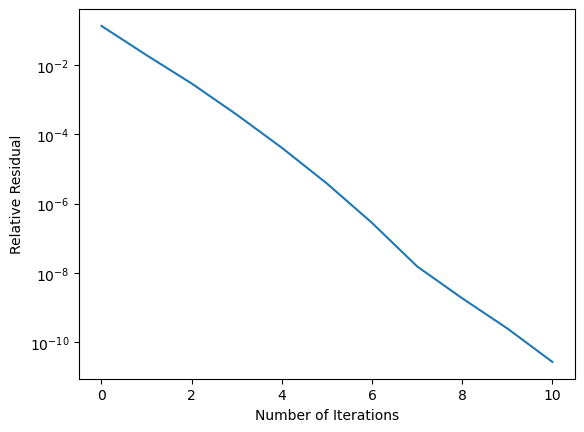

In [20]:
# Main Code
n = 4
N = 2**n
h = 1 / N
x = np.linspace(0, 1, N + 1)
y = np.linspace(0, 1, N + 1)
f = 8 * np.pi**2 * np.sin(2 * np.pi * x[:, np.newaxis]) * np.sin(2 * np.pi * y[np.newaxis, :])
u_0 = np.zeros((N + 1, N + 1))
gamma = 2
nu1 = 2
nu2 = 1
r_0 = np.abs(np.max(f))
relConv = []
itnum = 1
            
start = time.time()

while True:
    u_out = multiGrid(u_0, f, gamma, nu1, nu2)
    r_inf = resInfNorm(residual(u_out, f))
    u_0 = u_out
    if itnum > 0:
        relRes = r_inf / r_0
        relConv.append(relRes)
        if relRes < 1e-10:
            break
    itnum+=1

end = time.time()
print(end - start)

print(itnum)
print(relConv[-1])

iterations = np.arange(0,itnum,1)
plot.semilogy(iterations,relConv)
plot.xlabel('Number of Iterations')
plot.ylabel('Relative Residual')
plot.show()